In [368]:
import math
import numpy as np
import PIL
from matplotlib import pyplot as plt
from PIL import Image
import time
from scipy import signal

def read_image(image_path):
    """Read an image into a numpy array.

    Args:
        image_path: Path to the image file.

    Returns:
        Numpy array containing the image
    """
    img = Image.open(image_path)
    return np.array(img)


def write_image(image, out_path):
    """Writes a numpy array as an image file.

    Args:
        image: Numpy array containing image to write
        out_path: Path for the output image
    """
#     image = (image*255.0).astype('uint8')
#     image = image / image.max() * 255.0
    img = Image.fromarray(image)
    img.save(out_path)


def display_image(image):
    """Displays a grayscale image using matplotlib.

    Args:
        image: HxW Numpy array containing image to display.
    """
    #image = (image*255.0).astype('uint8')
    plt.imshow(image, cmap="gray")


def convert_to_grayscale(image):
    """Convert an RGB image to grayscale.

    Args:
        image: HxWx3 uint8-type Numpy array containing the RGB image to convert.

    Returns:
        uint8-type Numpy array containing the image in grayscale
    """
    H, W = image.shape[0], image.shape[1]
    grarray = np.zeros((H, W), dtype='uint8')
    for row in range(H):
        for col in range(W):
            pixel = image[row][col]
            R, G, B = pixel[0], pixel[1], pixel[2]
            L = (299/1000) * R + (587/1000) * G + (114/1000) * B
            grarray[row][col] = int(L)
    return grarray


def convert_to_float(image):
    """Convert an image from 8-bit integer to 64-bit float format

    Args:
        image: Integer-valued numpy array with values in [0, 255]
    Returns:
        Float-valued numpy array with values in [0, 1]
    """

    return image.astype('float64') / 255.0

#scipy.signal.convolve2d
def convolution(image, kernel):
    """Convolves image with kernel.

    The image should be zero-padded so that the input and output image sizes
    are equal.
    Args:
        image: HxW Numpy array, the grayscale image to convolve
        kernel: hxw numpy array
    Returns:
        image after performing convolution
    """
    H, W = image.shape
    h, w = kernel.shape
    k = (h - 1) // 2    #1/2 height
    l = (w - 1) // 2    #1/2 side  
    kernel = np.flipud(kernel)
    kernel = np.fliplr(kernel)
    convd = np.zeros((H, W))
    padded = np.pad(image, max(k, l), mode='constant', constant_values=0)
    for row in range(H):
        for col in range(W):
            local = padded[row:row+w, col:col+h]
            convd[row][col] = np.sum(local * kernel)
#             acc = 0
#             for r in range(-k, k+1):
#                 for c in range(-l, l+1):
#                     above = r + row < 0
#                     below = r + row > H - 1
#                     left = c + col < 0
#                     right = c + col > W - 1
#                     if not (above or below or left or right):
#                         acc += image[row+r][col+c] * kernel[r][c]
#             convd[row][col] = acc
    return convd



def gaussian_blur(image, ksize=3, sigma=1.0):
    """Blurs image by convolving it with a gaussian kernel.

    Args:
        image: HxW Numpy array, the grayscale image to blur
        ksize: size of the gaussian kernel
        sigma: variance for generating the gaussian kernel

    Returns:
        The blurred image
    """
    
    kernel = np.zeros((ksize, ksize))
    acc = 0
    radius = (ksize - 1) // 2
    for row in range(-radius, radius+1):
        for col in range(-radius, radius+1):
            val = math.exp(-(row**2+col**2)/(2*(sigma**2)))
            acc += val
            kernel[row+radius][col+radius] = val
    
    return convolution(image, kernel/acc)
    


def sobel_filter(image):
    """Detects image edges using the sobel filter.

    The sobel filter uses two kernels to compute the vertical and horizontal
    gradients of the image. The two kernels are:
    G_x = [-1 0 1]      G_y = [-1 -2 -1]
          [-2 0 2]            [ 0  0  0]
          [-1 0 1]            [ 1  2  1]

    After computing the two gradients, the image edges can be obtained by
    computing the gradient magnitude.

    Args:
        image: HxW Numpy array, the grayscale image
    Returns:
        HxW Numpy array from applying the sobel filter to image
    """
    G_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    G_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    #element-wise distance between x and y gradient
    x = convolution(image, G_x)
    y = convolution(image, G_y)
    
    return np.sqrt(np.square(x) + np.square(y))


def dog(image, ksize1=5, sigma1=1.0, ksize2=9, sigma2=2.0):
    """Detects image edges using the difference of gaussians algorithm

    Args:
        image: HxW Numpy array, the grayscale image
        ksize1: size of the first gaussian kernel
        sigma1: variance of the first gaussian kernel
        ksize2: size of the second gaussian kernel
        sigma2: variance of the second gaussian kernel
    Returns:
        HxW Numpy array from applying difference of gaussians to image
    """
    return gaussian_blur(image, ksize1, sigma1) - gaussian_blur(image, ksize2, sigma2)


def dft(image):
    """Computes the discrete fourier transform of image

    This function should return the same result as
    np.fft.fftshift(np.fft.fft2(image)). You may assume that
    image dimensions will always be even.

    Args:
        image: HxW Numpy array, the grayscale image
    Returns:
        HxW complex Numpy array, the fourier transform of the image
    """
    image = image.astype(np.complex128)
    H, W = image.shape
    F = np.zeros((H, W), dtype=np.complex128)
    for k in range(-H//2, H//2):
        for l in range(-W//2, W//2):
            for x in range(H):
                for y in range(W):
                    F[k+H//2][l+W//2] += image[x][y]*math.e**(-1.0j*2.0*math.pi*k*x/H-1.0j*2*math.pi*l*y/W)
    return F


def idft(ft_image):
    """Computes the inverse discrete fourier transform of ft_image.

    For this assignment, the complex component of the output should be ignored.
    The returned array should NOT be complex. The real component should be
    the same result as np.fft.ifft2(np.fft.ifftshift(ft_image)). You
    may assume that image dimensions will always be even.

    Args:
        ft_image: HxW complex Numpy array, a fourier image
    Returns:
        NxW float Numpy array, the inverse fourier transform
    """
    H, W = ft_image.shape
    f = np.zeros((H, W), dtype='float64')
    for x in range(H):
        for y in range(W):
            for k in range(-H//2, H//2):
                for l in range(-W//2, W//2):
                    f[x][y] += ft_image[k+H//2][l+W//2]*math.e**(1.0j*2.0*math.pi*k*x/H+1.0j*2*math.pi*l*y/W)
    return f

def visualize_kernels():
    """Visualizes your implemented kernels.

    This function should read example.png, convert it to grayscale and float-type,
    and run the functions gaussian_blur, sobel_filter, and dog over it. For each function,
    visualize the result and save it as example_{function_name}.png e.g. example_dog.png.
    This function does not need to return anything.
    """
    example = convert_to_float(read_image("example.png"))
    
    gauss = gaussian_blur(example)
    display_image(gauss)
    gauss -= gauss.min()
    write_image((gauss/gauss.max()*255.0).astype('uint8'), "example_gaussian_blur.png")

    sobel = sobel_filter(example)
    display_image(sobel)
    sobel -= sobel.min()
    write_image((sobel/sobel.max()*255.0).astype('uint8'), "example_sobel_filter.png")
    
    dg = dog(example)
    display_image(dg)
    dg -= dg.min()
    write_image((dg/dg.max()*255.0).astype('uint8'), "example_dog.png")

def visualize_dft():
    """Visualizes the discrete fourier transform.

    This function should read example.png, convert it to grayscale and float-type,
    and run dft on it. Try masking out parts of the fourier transform image and
    recovering the original image using idft. Can you create a blurry version
    of the original image? Visualize the blurry image and save it as example_blurry.png.
    This function does not need to return anything.
    """
    example_small = convert_to_float(read_image("example_small.png"))
    (H,W) = example_small.shape
    
    ksize = 5 #odd
    sigma = 1
    radius = (ksize-1)//2
    #generate gaussian kernel
    kernel = np.zeros((ksize, ksize))
    acc = 0
    for row in range(-radius, radius+1):
        for col in range(-radius, radius+1):
            val = math.exp(-(row**2+col**2)/(2*(sigma**2)))
            acc += val
            kernel[row+radius][col+radius] = val
            
    kernel = np.pad(kernel/acc, [(0, H), (0, W)], mode='constant')
    example_small = np.pad(example_small, [(0, ksize), (0, ksize)], mode='constant')
    
    img = idft(dft(kernel) * dft(example_small))
    
    img = img[radius:H+radius, radius:W+radius]
    img -= img.min()
    write_image((img/img.max()*255.0).astype('uint8'), "example_blurry.png")



[[0.45490196 0.44705882 0.43137255 ... 0.30980392 0.36862745 0.42745098]
 [0.44705882 0.43529412 0.41960784 ... 0.29411765 0.34509804 0.40392157]
 [0.44313725 0.42745098 0.41568627 ... 0.2627451  0.30980392 0.35686275]
 ...
 [0.86666667 0.8        0.72941176 ... 0.17647059 0.20784314 0.23921569]
 [0.92941176 0.86666667 0.78431373 ... 0.19607843 0.23137255 0.25882353]
 [0.98431373 0.91764706 0.83921569 ... 0.21960784 0.25490196 0.27843137]]


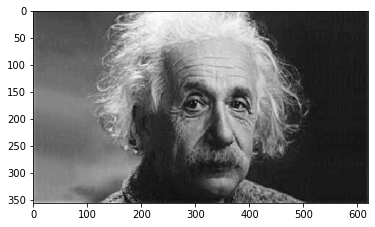

In [313]:
example = read_image("example.png")
small = read_image('example_small.png')
example = convert_to_float(example)
print(example)
display_image(example)

/Users/michaelzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: ComplexWarning: Casting complex values to real discards the imaginary part


[[168448. 159488. 157696. ...  87808.  86016.  91392.]
 [170240. 159488. 159488. ...  82432.  80640.  86016.]
 [173824. 163072. 163072. ...  84224.  82432.  86016.]
 ...
 [274176. 259840. 259840. ...  71680.  71680.  77056.]
 [277760. 263424. 263424. ...  69888.  69888.  75264.]
 [290304. 277760. 277760. ...  69888.  69888.  75264.]]


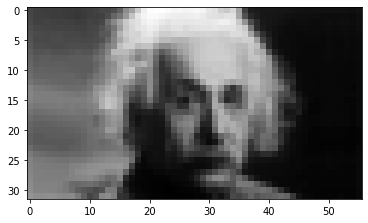

In [309]:
d = idft(dft(small))
display_image(d)
print(d)

In [310]:
print(d.max())
print(d.min())

451584.0000000009
62720.00000000072


In [86]:
a = np.fft.fftshift(np.fft.fft2(small))
b = dft(small)

In [100]:
print(a)

[[-99.        +7.68274333e-14j -61.33523187+2.63159819e+01j
  110.49820055-5.32873826e+00j ... -52.06829102+5.30346936e+01j
  110.49820055+5.32873826e+00j -61.33523187-2.63159819e+01j]
 [-47.08865295+3.10343818e+01j  21.426012  +7.89421652e+01j
  -87.21463653-4.98596771e+01j ...  26.3350773 +1.22505008e+02j
    1.26859176-8.23573902e+00j -73.53714304-1.18282260e+02j]
 [-11.64547504+8.19108144e+00j -70.8373321 -4.01029479e+01j
   52.96803647-7.58030753e+01j ...  27.66985673-6.80042012e+01j
   25.21792293-4.53906198e+01j -66.42414982+6.26473280e+01j]
 ...
 [-37.29830654+2.40379119e+01j  71.7228817 +2.72815830e+01j
  -79.76603894-2.24355789e+01j ...  29.20640092-3.58833279e+01j
    6.05044732-2.06040468e+00j -39.86134377-1.03023495e+01j]
 [-11.64547504-8.19108144e+00j -66.42414982-6.26473280e+01j
   25.21792293+4.53906198e+01j ... -87.43744154-9.18501771e+01j
   52.96803647+7.58030753e+01j -70.8373321 +4.01029479e+01j]
 [-47.08865295-3.10343818e+01j -73.53714304+1.18282260e+02j
    1.2685

In [101]:
print(b)

[[-99.        -2.30283772e-11j -61.33523187+2.63159819e+01j
  110.49820055-5.32873826e+00j ... -52.06829102+5.30346936e+01j
  110.49820055+5.32873826e+00j -61.33523187-2.63159819e+01j]
 [-47.08865295+3.10343818e+01j  21.426012  +7.89421652e+01j
  -87.21463653-4.98596771e+01j ...  26.3350773 +1.22505008e+02j
    1.26859176-8.23573902e+00j -73.53714304-1.18282260e+02j]
 [-11.64547504+8.19108144e+00j -70.8373321 -4.01029479e+01j
   52.96803647-7.58030753e+01j ...  27.66985673-6.80042012e+01j
   25.21792293-4.53906198e+01j -66.42414982+6.26473280e+01j]
 ...
 [-37.29830654+2.40379119e+01j  71.7228817 +2.72815830e+01j
  -79.76603894-2.24355789e+01j ...  29.20640092-3.58833279e+01j
    6.05044732-2.06040468e+00j -39.86134377-1.03023495e+01j]
 [-11.64547504-8.19108144e+00j -66.42414982-6.26473280e+01j
   25.21792293+4.53906198e+01j ... -87.43744154-9.18501771e+01j
   52.96803647+7.58030753e+01j -70.8373321 +4.01029479e+01j]
 [-47.08865295-3.10343818e+01j -73.53714304+1.18282260e+02j
    1.2685

In [98]:
print(a-b > 0.000000001)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [89]:
print(b)

[[-99.        -2.30283772e-11j -61.33523187+2.63159819e+01j
  110.49820055-5.32873826e+00j ... -52.06829102+5.30346936e+01j
  110.49820055+5.32873826e+00j -61.33523187-2.63159819e+01j]
 [-47.08865295+3.10343818e+01j  21.426012  +7.89421652e+01j
  -87.21463653-4.98596771e+01j ...  26.3350773 +1.22505008e+02j
    1.26859176-8.23573902e+00j -73.53714304-1.18282260e+02j]
 [-11.64547504+8.19108144e+00j -70.8373321 -4.01029479e+01j
   52.96803647-7.58030753e+01j ...  27.66985673-6.80042012e+01j
   25.21792293-4.53906198e+01j -66.42414982+6.26473280e+01j]
 ...
 [-37.29830654+2.40379119e+01j  71.7228817 +2.72815830e+01j
  -79.76603894-2.24355789e+01j ...  29.20640092-3.58833279e+01j
    6.05044732-2.06040468e+00j -39.86134377-1.03023495e+01j]
 [-11.64547504-8.19108144e+00j -66.42414982-6.26473280e+01j
   25.21792293+4.53906198e+01j ... -87.43744154-9.18501771e+01j
   52.96803647+7.58030753e+01j -70.8373321 +4.01029479e+01j]
 [-47.08865295-3.10343818e+01j -73.53714304+1.18282260e+02j
    1.2685

TypeError: Image data of dtype complex128 cannot be converted to float

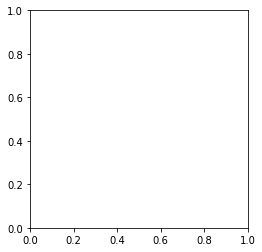

In [99]:
display_image(b)

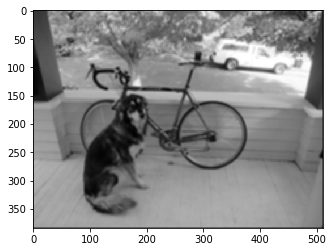

In [240]:
k = np.zeros((5,5)) + (1/25)
display_image(convolution(convert_to_grayscale(read_image('dogbike.jpg')), k))

In [ ]:
display_image(convert_to_grayscale(read_image('dogbike.jpg')))

4.982882962020958

[[ 30.48951584  42.63622141  43.23308644 ... 107.68329857  73.28794679
   26.008212  ]
 [ 41.82995148  58.58092911  59.52697637 ... 135.84319932  92.77396032
   31.87303825]
 [ 41.95901782  58.6783847   59.77988412 ... 117.39848251  82.25184515
   26.72062894]
 ...
 [119.47181736 164.04754668 163.23056577 ... 103.07219509  80.63364493
   37.7706188 ]
 [118.81577465 163.31639036 162.4941845  ...  95.39667311  70.72325226
   31.48533872]
 [ 64.98721885  89.32402783  88.92207398 ...  51.72557456  37.96128432
   16.67522097]]


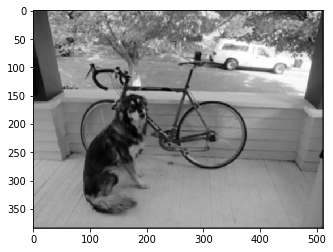

In [171]:
a = gaussian_blur(convert_to_grayscale(read_image('dogbike.jpg')), 3,1)
display_image(a)
print(a)

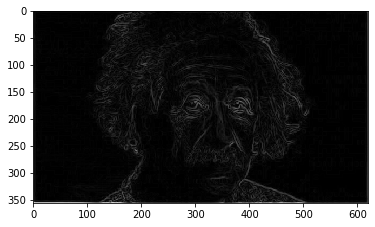

In [278]:
sob = sobel_filter(example)
display_image(sob/sob.max()*255.0)

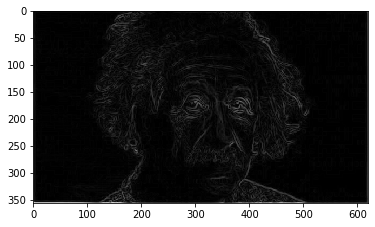

In [280]:
display_image(sob)

In [215]:
a = sobel_filter(example)
print(a)

[[1.90780183 1.76498473 1.7104514  ... 1.32288873 1.54174016 0.81540342]
 [1.78851047 0.06678191 0.06323339 ... 0.15469085 0.22142109 0.21693046]
 [1.76873614 0.06949037 0.06678191 ... 0.171924   0.23299531 0.2018751 ]
 ...
 [3.55110111 0.30137453 0.34375854 ... 0.0942809  0.15258883 0.12175823]
 [3.76980863 0.35532961 0.37306466 ... 0.11699164 0.16006535 0.11433239]
 [1.92014353 0.25153126 0.26277436 ... 0.0968556  0.11147192 0.06678191]]


In [217]:
print(a/a.max()*255.0)

[[121.60740597 112.50393591 109.02786376 ...  84.3237831   98.27384506
   51.97557389]
 [114.00351756   4.25682291   4.03063302 ...   9.86032842  14.1138579
   13.82761558]
 [112.74305895   4.42946636   4.25682291 ...  10.95880693  14.8516237
   12.86795463]
 ...
 [226.35484926  19.21026277  21.91191135 ...   6.00966832   9.72634167
    7.76113256]
 [240.2957387   22.6494762   23.77994653 ...   7.45729953  10.20291063
    7.28779331]
 [122.39409281  16.03314528  16.74980497 ...   6.17378501   7.10546107
    4.25682291]]


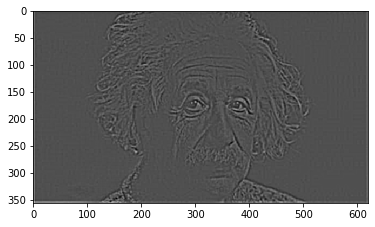

In [241]:
display_image(dog(example))

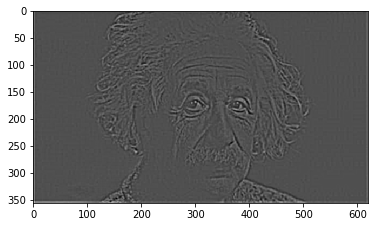

In [70]:
visualize_kernels()

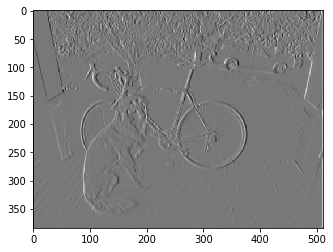

In [273]:
k = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
# k = np.zeros((3, 3)) + (1/9)
s = signal.convolve(convert_to_grayscale(read_image('dogbike.jpg')), k, mode="same")
c = convolution(convert_to_grayscale(read_image('dogbike.jpg')), k)
display_image(s)


In [274]:
print(s.astype('uint8')==c.astype('uint8'))
# print(c)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [275]:
print(s)

[[-176   -9   -4 ...  376  441  258]
 [-233  -13   -7 ...  579  557  263]
 [-233  -14   -8 ...  682  431  153]
 ...
 [-655   13    2 ...  180  240  322]
 [-651   13   -2 ...  215  264  280]
 [-485   11   -1 ...  174  203  193]]


In [276]:
print(c)

[[-176.   -9.   -4. ...  376.  441.  258.]
 [-233.  -13.   -7. ...  579.  557.  263.]
 [-233.  -14.   -8. ...  682.  431.  153.]
 ...
 [-655.   13.    2. ...  180.  240.  322.]
 [-651.   13.   -2. ...  215.  264.  280.]
 [-485.   11.   -1. ...  174.  203.  193.]]


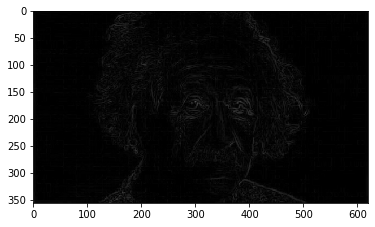

In [199]:
sobel = sobel_filter(example)
display_image(sobel)
write_image(sobel, "example_sobel_filter.png")

/Users/michaelzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: ComplexWarning: Casting complex values to real discards the imaginary part


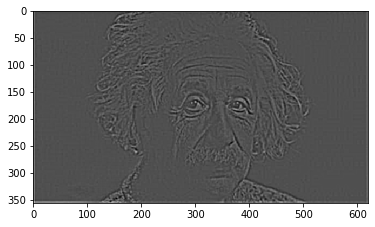

In [314]:
visualize_kernels()
visualize_dft()

In [365]:
visualize_dft()

/Users/michaelzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:223: ComplexWarning: Casting complex values to real discards the imaginary part


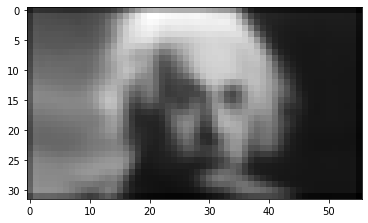

In [369]:
display_image(gaussian_blur(example_small))

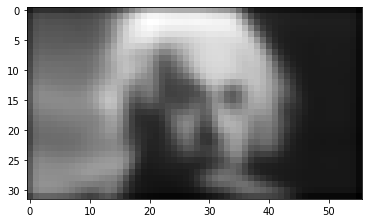

In [367]:
display_image(gaussian_blur(example_small, 5, 1.0))